In this notebook we will use the Quil simulator to run a few example quantum circuits. To demonstrate what these gates do we will plot the state evolution on the Bloch sphere.

In [1]:
import subprocess
from pyquil.api import QVMConnection

# Start the quantum simulator server in a subprocess
qvm_server = subprocess.Popen(["/src/qvm/qvm", "-S"])
# Connect to the simulator
qvm = QVMConnection()

In [2]:
from pyquil.quil import Program, Declare
from pyquil.gates import X, MEASURE, RX, H

In [3]:
import pylab as pl
import numpy as np
from qutip import Bloch, basis

This program runs an X pulse (or a "NOT" gate) and measures it. The result is stored in classical address 0.

In [4]:
program = Program()
ro = program.declare('ro', 'BIT')

program += X(0)
program += MEASURE(0, ro[0])

In [5]:
print(program)

DECLARE ro BIT[1]
X 0
MEASURE 0 ro[0]



In [6]:
wfn = qvm.wavefunction(program)

In [7]:
program = Program()
ro = program.declare('ro', 'BIT')

program += H(0)
program += MEASURE(0, ro[0])

qvm.run(program, trials=10)

[[1], [0], [0], [0], [1], [1], [1], [0], [1], [1]]

In [8]:
import pylab as pl
from matplotlib import animation, rc
from IPython.display import HTML
import numpy as np

def plot_bloch_sphere(state, fig, ax):
    b = Bloch(fig=fig, axes=ax)
    b.add_states(state)
    b.render(fig=fig, axes=ax)
    
def get_quantum_state(program):
    wfn = qvm.wavefunction(program)
    state = np.dot(wfn.amplitudes, [basis(2, 0), basis(2, 1)])
    return state

-0.7071067812j|0> + -0.7071067812j|1>


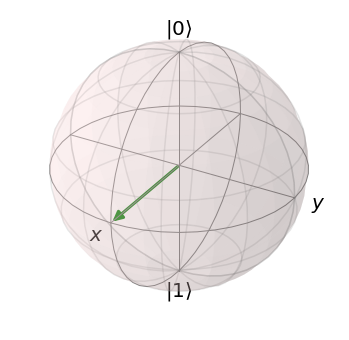

In [28]:
from pyquil.gates import RX, RY

program = Program()
program += RY(np.pi / 2, 0)
program += RX(np.pi, 0)

fig = pl.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

state = get_quantum_state(program)
plot_bloch_sphere(state, fig, ax)
wfn = qvm.wavefunction(program)
print(wfn)

In [11]:
# Functions to animate an evolving quantum state using Matplotlib
def animate(fig, ax, evolve_quantum_state):
    def _animate(i):
        ax.clear()
        program = evolve_quantum_state(i)
        state = get_quantum_state(program)
        plot_bloch_sphere(state, fig=fig, ax=ax)
        return (ax.artists[0],)
    return _animate

def show_animation(fig, ax, evolve_quantum_state, num_frames=10):
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate(fig, ax, evolve_quantum_state), 
                                   init_func=lambda: animate(fig, ax, evolve_quantum_state)(0),
                                   frames=num_frames+1, interval=100, blit=True)
    return HTML(anim.to_jshtml())

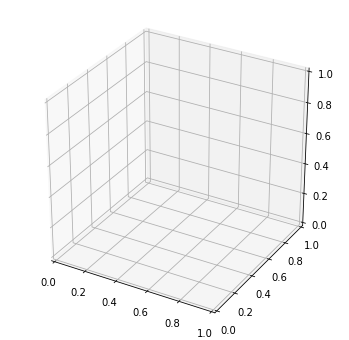

In [12]:
fig = pl.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

In [13]:
from pyquil.gates import RX, RY, RZ

def x(i, num_frames = 10, alpha = np.pi):
    # Rotate X by π
    theta = i * alpha / num_frames
    program = Program()
    program += RX(theta, 0)

    return program

def y(i, num_frames = 10, alpha = np.pi):
    # Rotate Y by π
    theta = i * alpha / num_frames
    program = Program()
    program += RY(theta, 0)

    return program


def hadamard(i, num_frames = 30):
    # Rotate Y by π/2, X by π
    n = num_frames // 3  # Number of frames per rotation
    if i < n:
        return y(i, num_frames=n, alpha=np.pi/2)
    else:
        return y(n, num_frames=n, alpha=np.pi/2) + x(i-n, num_frames=2*n, alpha=np.pi)

    return program


def z(i, num_frames = 10, alpha = np.pi):
    # Rotate Z by π
    theta = i * alpha / num_frames
    program = Program()
    program += RZ(theta, 0)

    return program


def yzx_pi_2(i, num_frames = 30):
    # Rotate Y by π/2, Z by π, X by π/2
    n = num_frames // 3  # Number of frames per rotation
    if i <= n:
        return y(i, num_frames=n, alpha=np.pi/2)
    elif i <= 2 * n:
        return yzx_pi_2(n, num_frames) + z(i - n, num_frames=n, alpha=np.pi/2)
    else:
        return yzx_pi_2(2 * n, num_frames) + x(i - 2 * n, num_frames=n, alpha=-np.pi/2) 

    return program

In [14]:
print(hadamard(3, 3))

RY(pi/2) 0
RX(pi) 0



In [15]:
print(x(1,1,np.pi/2))

RX(pi/2) 0



In [16]:
show_animation(fig, ax, lambda i: x(i, num_frames=20), num_frames=10)

In [17]:
show_animation(fig, ax, lambda i: y(i, num_frames=30), num_frames=30)

In [18]:
print(yzx_pi_2(3, 3))

RY(pi/2) 0
RZ(pi/2) 0
RX(-pi/2) 0



In [19]:
show_animation(fig, ax, lambda i: yzx_pi_2(i, num_frames=60), num_frames=60)

## Entanglement

Let's entangle two qubits!

In [20]:
from pyquil.gates import H, CNOT

In [21]:
program = Program()
ro = program.declare('ro', 'BIT', memory_size=2)
program += H(0)
program += CNOT(0, 1)
program += MEASURE(0, ro[0])
program += MEASURE(1, ro[1])

In [22]:
single_shot_data = qvm.run(program, classical_addresses=[0, 1], trials=10)
single_shot_data

[[1, 1],
 [1, 1],
 [0, 0],
 [0, 0],
 [1, 1],
 [0, 0],
 [1, 1],
 [1, 1],
 [0, 0],
 [1, 1]]

### Entanglement using native CZ gate

Quil's natural gateset uses a CZ instead of a CNOT. One can transform a CNOT into CZs and thereby run the entangling operation as follows:

In [23]:
from pyquil.gates import CZ

program = Program()
ro = program.declare('ro', 'BIT', memory_size=2)
program += H(0)
program += H(1)
program += CZ(0, 1)
program += H(1)
program += MEASURE(0, ro[0])
program += MEASURE(1, ro[1])

qvm.run(program, classical_addresses=[0, 1], trials=10)

[[1, 1],
 [0, 0],
 [1, 1],
 [1, 1],
 [0, 0],
 [0, 0],
 [1, 1],
 [0, 0],
 [1, 1],
 [1, 1]]

## Plot the parity

Evaluate the following lines to plot the results of the single shot data for the entangling operation.

In [24]:
%pylab inline
parity = {
    (0, 0): 0,
    (0, 1): 1,
    (1, 0): 2,
    (1, 1): 3
}

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [25]:
def plot_parity(single_shot_data, title="Bell test results"):
    plt.hist([parity[(u, v)] for (u, v) in single_shot_data])
    plt.xticks(list(parity.values()), parity.keys())
    plt.title(title)
    ;

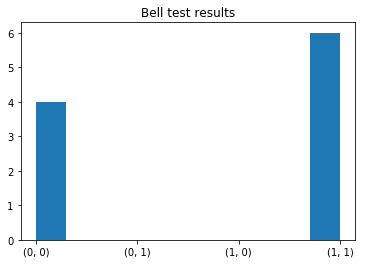

In [26]:
plot_parity(single_shot_data)

In [27]:
qvm_server.terminate()